Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3265 - val_loss: 0.0707
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0557 - val_loss: 0.0791
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0748 - val_loss: 0.0770
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0607 - val_loss: 0.0345
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - val_loss: 0.0297
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.0346
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0253 - val_loss: 0.0277
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - val_loss: 0.0163
Epoch 9/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0143
Epoch 10/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0137
Epoch 11/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 12/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099 - val_loss: 0.0114
Epoch 13/15


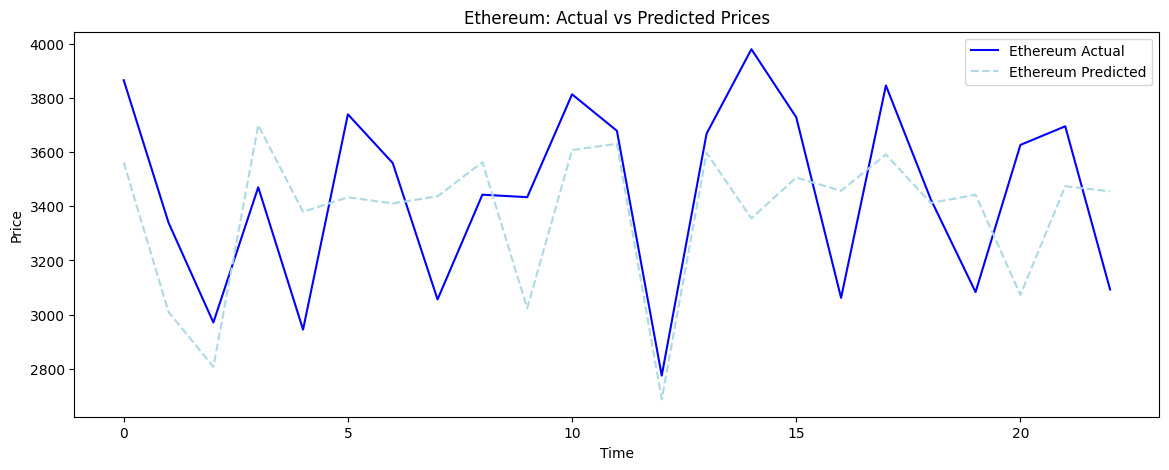

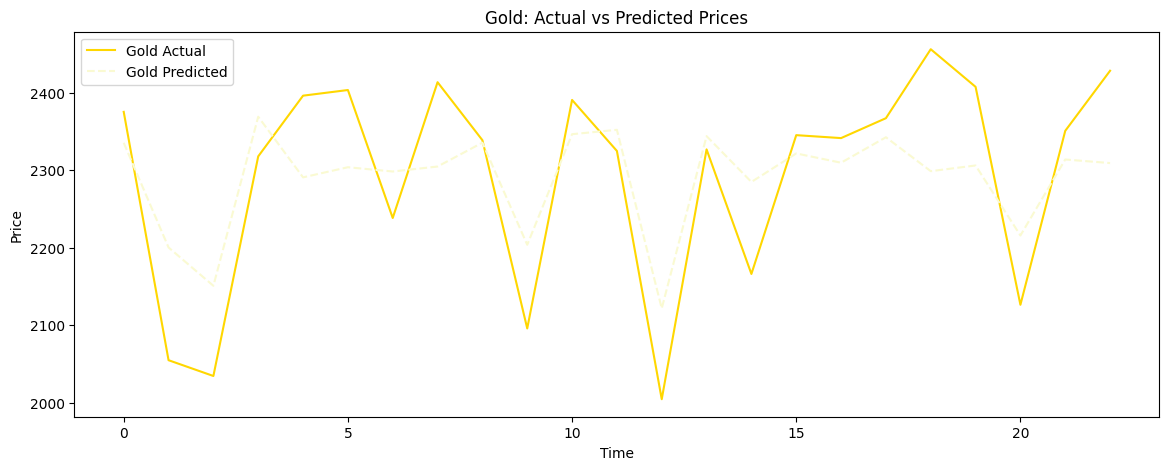

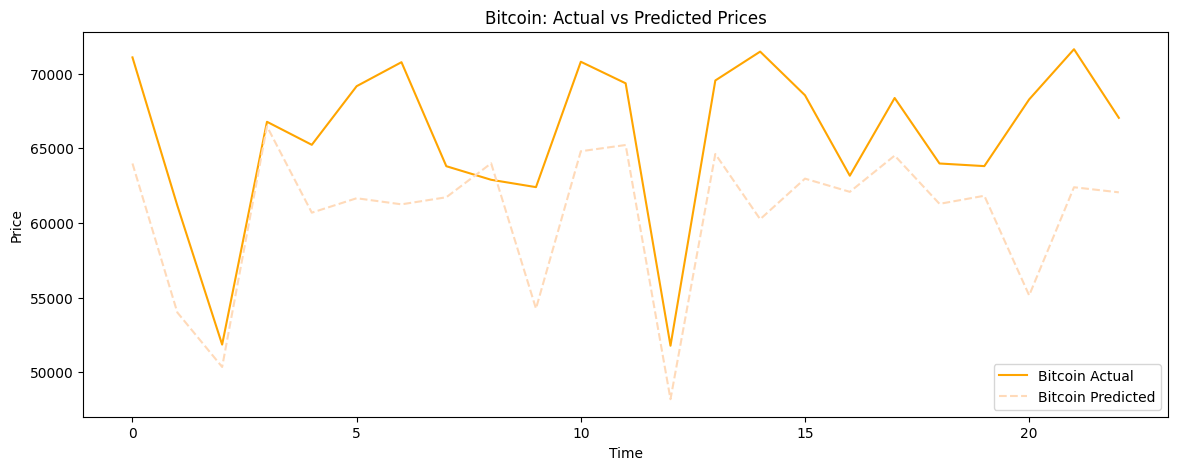

In [9]:
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import matplotlib.pyplot as plt

# Data Loading Step

# Load CSV files
ethereum_df = pd.read_csv("/data_files/ethereum_prices.csv")  
gold_df = pd.read_csv("/data_files/gold_prices.csv")          
bitcoin_df = pd.read_csv("/data_files/bitcoin_prices.csv")    

# Merge DataFrames on the 'Date' column
df = pd.merge(pd.merge(ethereum_df, gold_df, on='Date'), bitcoin_df, on='Date')

# Rename columns for clarity
df.columns = ['Date', 'ethereum', 'gold', 'bitcoin']

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Sort DataFrame by date
df = df.sort_values('Date')

# Fill missing values
df = df.ffill()

# Data Preprocessing

# Parameters
n_steps = 30  # 30 Day lookback
n_features = 3  # Number of parallel time series streams
test_size = 0.2  # Proportion of data for testing

# Prepare Data
def prepare_data(df, n_steps):
    df_values = df[['ethereum', 'gold', 'bitcoin']].values
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df_values)
    
    X, y = [], []
    for i in range(n_steps, len(df_scaled)):
        X.append(df_scaled[i-n_steps:i])
        y.append(df_scaled[i])
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y, scaler

X, y, scaler = prepare_data(df, n_steps)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#Convolutional Feature Identification

# Define the Convolutional Feature Extractor
conv_model = models.Sequential()

# Using an Input layer to establich shape
conv_model.add(layers.Input(shape=(n_steps, n_features)))
conv_model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
conv_model.add(layers.MaxPooling1D(pool_size=2))
conv_model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
conv_model.add(layers.MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
conv_model.add(layers.Flatten())

# Add a Dense layer with 1 unit to output a single combined value
conv_model.add(layers.Dense(1, activation='linear'))

# Compile the convolutional model
conv_model.compile(optimizer='adam', loss='mse')

# Fit the convolutional model
conv_model.fit(X_train, y_train.mean(axis=1), epochs=15, batch_size=32, validation_split=0.2)

# Extract features from the convolutional model
conv_features_train = conv_model.predict(X_train)
conv_features_test = conv_model.predict(X_test)

#Feed features to Chronos

# Chronos Model Prediction
chronos_input_train = torch.tensor(conv_features_train, dtype=torch.bfloat16).to('cpu')
chronos_input_test = torch.tensor(conv_features_test, dtype=torch.bfloat16).to('cpu')

# Initialize Chronos Pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference
    torch_dtype=torch.bfloat16,
)

# Predict with Chronos Model
def predict_with_chronos(chronos_input, prediction_length=1, num_samples=10):
    forecasts = []
    for i in range(chronos_input.shape[0]):
        forecast = pipeline.predict(
            context=chronos_input[i],
            prediction_length=prediction_length,
            num_samples=num_samples,
        )
        # Average the samples if multiple are generated
        forecast_mean = forecast.mean(dim=0).detach().cpu().numpy()
        forecasts.append(forecast_mean)
    return np.array(forecasts)

# Generate predictions with 10 samples
chronos_forecast = predict_with_chronos(chronos_input_test)

# Ensure the shape matches before reshaping
chronos_forecast = chronos_forecast.mean(axis=1)  # Average across the 10 samples to match y_test's shape

# Check the shape of y_test and chronos_forecast
print(f"Shape of chronos_forecast: {chronos_forecast.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Verify that the number of predictions matches the number of targets
if chronos_forecast.shape[0] != y_test.shape[0]:
    raise ValueError(f"Number of predictions ({chronos_forecast.shape[0]}) does not match number of targets ({y_test.shape[0]}).")

# Reshape the chronos_forecast for prediction
chronos_forecast_reshaped = chronos_forecast.reshape(-1, 1)

#Decomposition process (flat weights)

# Define Trainable Weights Layer
class DecompositionLayer(layers.Layer):
    def __init__(self):
        super(DecompositionLayer, self).__init__()
        self.w1 = self.add_weight(shape=(1,), initializer='ones', trainable=True, name="weight_ethereum")
        self.w2 = self.add_weight(shape=(1,), initializer='ones', trainable=True, name="weight_gold")
        self.w3 = self.add_weight(shape=(1,), initializer='ones', trainable=True, name="weight_bitcoin")
    
    def call(self, inputs):
        ethereum_pred = inputs / self.w1
        gold_pred = inputs / self.w2
        bitcoin_pred = inputs / self.w3
        return tf.stack([ethereum_pred, gold_pred, bitcoin_pred], axis=1)

# Apply the Decomposition Layer to Chronos Forecast
decomposition_input = tf.keras.Input(shape=(1,))
decomposition_output = DecompositionLayer()(decomposition_input)

decomposition_model = tf.keras.Model(inputs=decomposition_input, outputs=decomposition_output)

# Compile the decomposition model
decomposition_model.compile(optimizer='adam', loss='mse')

# Train the decomposition model using the Chronos forecast and the actual values
decomposition_model.fit(chronos_forecast_reshaped, y_test, epochs=10, batch_size=32, validation_split=0.2)

# Predict using the trained decomposition model
predictions = decomposition_model.predict(chronos_forecast_reshaped)

# Reshape predictions to be 2D
predictions_reshaped = predictions.reshape(predictions.shape[0], -1)

# Inverse scale the decomposed predictions to get original values
predictions_rescaled = scaler.inverse_transform(predictions_reshaped)
y_test_rescaled = scaler.inverse_transform(y_test)

# Display results
for i in range(5):  # Display first 5 predictions
    print(f"Predicted: {predictions_rescaled[i]}, Actual: {y_test_rescaled[i]}")

# Visualization Step: Separate Plots for Each Asset

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled[:, 0], label='Ethereum Actual', color='blue')
plt.plot(predictions_rescaled[:, 0], label='Ethereum Predicted', color='lightblue', linestyle='dashed')
plt.title('Ethereum: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled[:, 1], label='Gold Actual', color='gold')
plt.plot(predictions_rescaled[:, 1], label='Gold Predicted', color='lightgoldenrodyellow', linestyle='dashed')
plt.title('Gold: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_rescaled[:, 2], label='Bitcoin Actual', color='orange')
plt.plot(predictions_rescaled[:, 2], label='Bitcoin Predicted', color='peachpuff', linestyle='dashed')
plt.title('Bitcoin: Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
